# 🛠️ Baseline Evaluation: (s,S) Policy

Evaluate the (s,S) baseline policy using the simulation engine.

**Goal**: Establish baseline metrics for RL agent comparison

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: Import (s,S) Policy

In [2]:
from src.baseline import sSPolicy
from src.mdp import create_state

# Policy parameters (from theory notebook calculations)
policy = sSPolicy(params=((9, 21), (8, 22)), Q_max=20)
print(policy)

# Quick test
test_state = create_state(10, 8, 0, 0)
action = policy(test_state)
print(
    f"\nTest: IP=({test_state.get_inventory_position(0)}, {test_state.get_inventory_position(1)})"
)
print(f"  → Order: {action.order_quantities}")

(s,S) Policy: P0=(9, 21), P1=(8, 22), Q_max=20

Test: IP=(10, 8)
  → Order: (0, 14)


## Part 2: Simple Simulation Test

In [3]:
from src.simulation import InventorySimulation
from src.mdp import RewardFunction

sim = InventorySimulation(random_state=np.random.default_rng(42))
reward_fn = RewardFunction()

initial_state = create_state(0, 0, 0, 0)
sim.reset(initial_state)

print("=" * 60)
print("SIMULATION: 1 Month (30 days)")
print("=" * 60)

total_cost = 0
for day in range(30):
    state = sim.get_current_state()
    action = policy(state)
    new_state, _ = sim.execute_daily_decision(action)

    costs = reward_fn.calculate_costs(new_state, action)
    total_cost += costs.total_cost

    if day < 5 or day >= 25:  # Show first/last 5 days
        print(
            f"Day {day+1:2d}: IP=({state.get_inventory_position(0):3d}, {state.get_inventory_position(1):3d}) "
            f"→ Order {action.order_quantities} → Cost ${costs.total_cost:.2f}"
        )

# Get statistics from built-in logger
all_stats = sim.logger.get_all_statistics()
total_customers = sum(s.num_customers for s in all_stats)
total_demand_0 = sum(s.total_demand_per_product.get(0, 0) for s in all_stats)
total_demand_1 = sum(s.total_demand_per_product.get(1, 0) for s in all_stats)

print(f"\n{'='*60}")
print(f"Total Cost: ${total_cost:.2f} | Avg Daily: ${total_cost/30:.2f}")
print(f"Customers: {total_customers} | Demand: ({total_demand_0}, {total_demand_1})")

SIMULATION: 1 Month (30 days)
Day  1: IP=(  0,   0) → Order (20, 20) → Cost $140.00
Day  2: IP=( 20,  20) → Order (0, 0) → Cost $0.00
Day  3: IP=( 20,  20) → Order (0, 0) → Cost $0.00
Day  4: IP=( 20,  20) → Order (0, 0) → Cost $0.00
Day  5: IP=( 20,  20) → Order (0, 0) → Cost $0.00
Day 26: IP=( 17,  15) → Order (0, 0) → Cost $36.00
Day 27: IP=( 17,  15) → Order (0, 0) → Cost $32.00
Day 28: IP=( 17,  15) → Order (0, 0) → Cost $32.00
Day 29: IP=( 17,  15) → Order (0, 0) → Cost $32.00
Day 30: IP=( 17,  15) → Order (0, 0) → Cost $32.00

Total Cost: $596.00 | Avg Daily: $19.87
Customers: 1 | Demand: (3, 5)


### Visualize Inventory Evolution (from Logger)

/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_12228/3370076918.py:31: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_12228/3370076918.py:31: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/marin/Documents/UNIMORE_4^anno/RL-InventorySystem/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


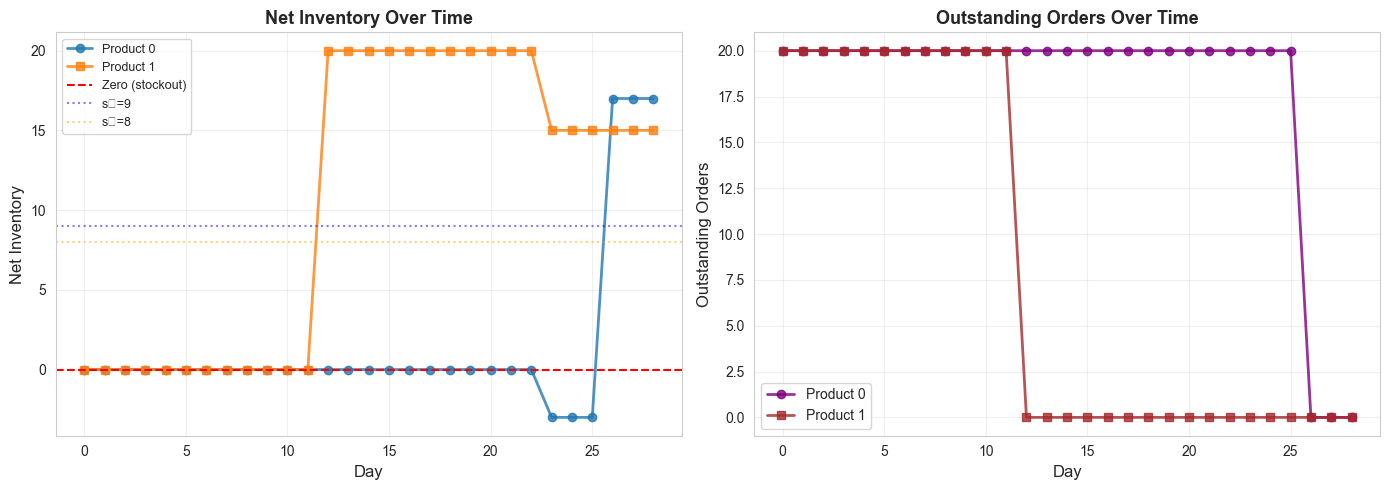

In [4]:
# Visualize using logger data (no manual tracking needed!)
days = [s.day for s in all_stats]
net_inv_0 = [s.net_inventory_per_product.get(0, 0) for s in all_stats]
net_inv_1 = [s.net_inventory_per_product.get(1, 0) for s in all_stats]
outstanding_0 = [s.outstanding_per_product.get(0, 0) for s in all_stats]
outstanding_1 = [s.outstanding_per_product.get(1, 0) for s in all_stats]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Net inventory
axes[0].plot(days, net_inv_0, marker='o', linewidth=2, label='Product 0', alpha=0.8)
axes[0].plot(days, net_inv_1, marker='s', linewidth=2, label='Product 1', alpha=0.8)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero (stockout)')
axes[0].axhline(policy.get_s_min(0), color='blue', linestyle=':', alpha=0.5, label=f's₀={policy.get_s_min(0)}')
axes[0].axhline(policy.get_s_min(1), color='orange', linestyle=':', alpha=0.5, label=f's₁={policy.get_s_min(1)}')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Net Inventory', fontsize=12)
axes[0].set_title('Net Inventory Over Time', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Outstanding orders
axes[1].plot(days, outstanding_0, marker='o', linewidth=2, label='Product 0', color='purple', alpha=0.8)
axes[1].plot(days, outstanding_1, marker='s', linewidth=2, label='Product 1', color='brown', alpha=0.8)
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Outstanding Orders', fontsize=12)
axes[1].set_title('Outstanding Orders Over Time', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Full Evaluation (100 Episodes)

In [5]:
def evaluate_policy(policy, num_episodes=100, days_per_episode=30, seed=42):
    """Evaluate policy over multiple episodes."""
    reward_fn = RewardFunction()
    all_costs = []
    initial_state = create_state(0, 0, 0, 0)  # Start empty

    for ep in range(num_episodes):
        sim = InventorySimulation(random_state=np.random.default_rng(seed + ep))
        sim.reset(initial_state)

        episode_cost = 0
        for _ in range(days_per_episode):
            state = sim.get_current_state()
            action = policy(state)
            new_state, _ = sim.execute_daily_decision(action)

            costs = reward_fn.calculate_costs(new_state, action)
            episode_cost += costs.total_cost

        avg_daily_cost = episode_cost / days_per_episode
        all_costs.append(avg_daily_cost)

        if (ep + 1) % 20 == 0:
            print(f"  Episode {ep+1}/{num_episodes}: Avg cost = ${avg_daily_cost:.2f}")

    return {
        "costs": all_costs,
        "mean": np.mean(all_costs),
        "std": np.std(all_costs),
        "ci_95": 1.96 * np.std(all_costs) / np.sqrt(len(all_costs)),
    }


print("=" * 60)
print("BASELINE EVALUATION")
print("=" * 60)
print(f"\nPolicy: {policy}")
print(f"Episodes: 100 × 30 days\n")

results = evaluate_policy(policy)

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"  Mean Cost:  ${results['mean']:.2f} per day")
print(f"  Std Dev:    ${results['std']:.2f}")
print(f"  95% CI:     ±${results['ci_95']:.2f}")
print(f"{'='*60}")

BASELINE EVALUATION

Policy: (s,S) Policy: P0=(9, 21), P1=(8, 22), Q_max=20
Episodes: 100 × 30 days

  Episode 20/100: Avg cost = $39.23
  Episode 40/100: Avg cost = $25.43
  Episode 60/100: Avg cost = $43.77
  Episode 80/100: Avg cost = $27.57
  Episode 100/100: Avg cost = $76.80

RESULTS
  Mean Cost:  $42.56 per day
  Std Dev:    $20.25
  95% CI:     ±$3.97


## Part 4: Visualize Results

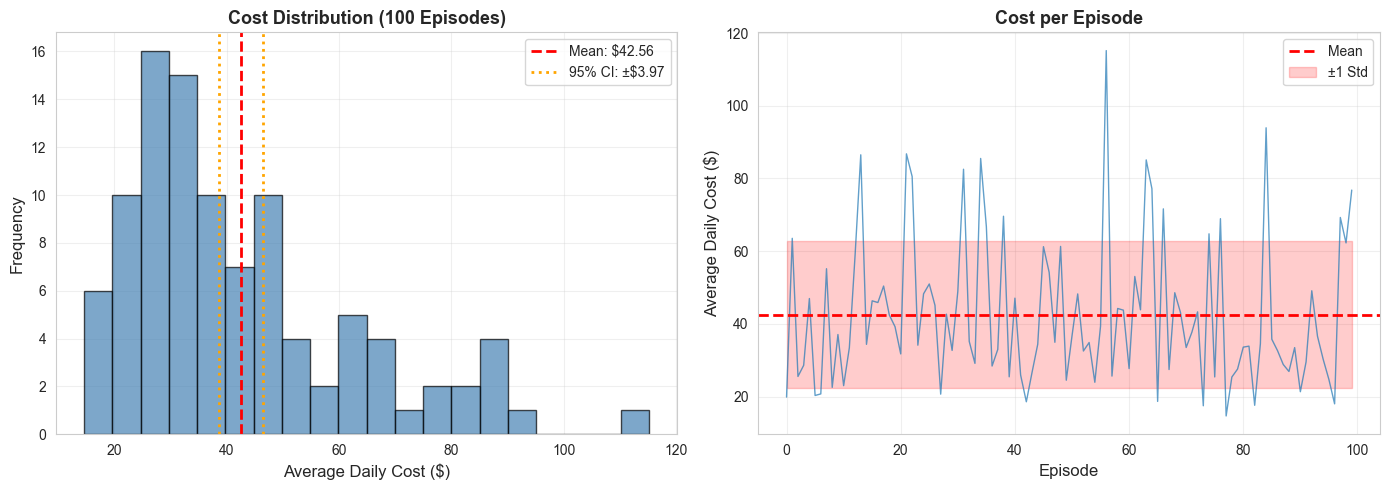

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost distribution
axes[0].hist(results['costs'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(results['mean'], color='red', linestyle='--', linewidth=2,
                label=f"Mean: ${results['mean']:.2f}")
axes[0].axvline(results['mean'] - results['ci_95'], color='orange', linestyle=':', linewidth=2)
axes[0].axvline(results['mean'] + results['ci_95'], color='orange', linestyle=':', linewidth=2,
                label=f"95% CI: ±${results['ci_95']:.2f}")
axes[0].set_xlabel('Average Daily Cost ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Cost Distribution (100 Episodes)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Cost over episodes
axes[1].plot(results['costs'], alpha=0.7, linewidth=1)
axes[1].axhline(results['mean'], color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].fill_between(range(len(results['costs'])),
                      results['mean'] - results['std'],
                      results['mean'] + results['std'],
                      alpha=0.2, color='red', label='±1 Std')
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Average Daily Cost ($)', fontsize=12)
axes[1].set_title('Cost per Episode', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Save Baseline Results

In [7]:
import json
from pathlib import Path

# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Prepare data
baseline_data = {
    'policy': str(policy),
    'params': policy.params,
    'evaluation': {
        'num_episodes': 100,
        'days_per_episode': 30,
        'mean_cost': float(results['mean']),
        'std_cost': float(results['std']),
        'ci_95': float(results['ci_95']),
    },
    'costs': [float(c) for c in results['costs']],
}

# Save
baseline_file = results_dir / 'baseline_sS_policy.json'
with open(baseline_file, 'w') as f:
    json.dump(baseline_data, f, indent=2)

print(f"✅ Baseline saved to: {baseline_file}")
print(f"\n📊 BASELINE BENCHMARK:")
print(f"   Target to beat: ${results['mean']:.2f} ± ${results['ci_95']:.2f} per day")

✅ Baseline saved to: ../results/baseline_sS_policy.json

📊 BASELINE BENCHMARK:
   Target to beat: $42.56 ± $3.97 per day


## 🎯 Summary

**Baseline Established:**
- Policy: (s,S) with calculated parameters
- Mean Cost: See results above
- 95% CI: See results above

**Next Steps:**
1. Train RL agents (DQN, PPO, A2C)
2. Compare against this baseline
3. Statistical significance tests

**Target**: Beat ${results['mean']:.2f}/day with lower variance!